# Imports

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from ipywidgets import interact, SelectionSlider

plt.rcParams["figure.figsize"] = (16, 4)

# Data load

Load train and test sets from respective .csv files

In [2]:
train_df = pd.read_csv("train.csv", index_col="S.No").drop_duplicates() # drop duplicate rows for training set
test_df = pd.read_csv("test.csv", index_col="S.No")

# Exploration

interactive widget to explore distributions and pairwise relationships

In [3]:
@interact(
    col1 = SelectionSlider(options=train_df.columns),
    col2 = SelectionSlider(options=train_df.columns),
    
)
def explore_scatter(col1, col2):
    fig, ax = plt.subplots(1, 3)
    
    ax[0].scatter(train_df[col1], train_df[col2], c=train_df.LABELS)
    ax[1].hist(train_df[col1])
    ax[1].set_title("train " + col1)
    ax[2].hist(train_df[col2])
    ax[2].set_title("train " + col2)

interactive(children=(SelectionSlider(description='col1', options=('lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT'…

# Data preparation

## prepare X data
transform features

In [4]:
def _scale_01(array):
    # to scale ordinal features, or bins
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def select_feature_subset(df, features_idx):
    # pass a list of column indices to filter features
    filtered_df = df.iloc[:, features_idx].copy()
    # if the dataframe contains "LABELS", add it back
    # this means the train set was passed
    if "LABELS" in df.columns:
        filtered_df["LABELS"] = df["LABELS"]
    
    return filtered_df

def drop_feature_subset(df, feature_list):
    # drop features passed in feature_list
    filtered_df = df.copy().drop(columns=feature_list)
    return filtered_df

def normalize_features(train_df, test_df, cols=['T200', 'TMQ', 'U850', 'V850', 'UBOT',
                                                'VBOT', 'QREFHT', 'PS', 'PSL']):
    train_norm = train_df[cols]
    test_norm = test_df[cols]

    train_mu = train_norm.mean(axis=0)
    train_sigma = train_norm.std(axis=0)
    # remove the train mean and standard deviation from the test set to avoid leakage
    train_norm = (train_norm - train_mu) / train_sigma
    test_norm = (test_norm - train_mu) / train_sigma
    
    train_df[cols] = train_norm
    test_df[cols] = test_norm
    return train_df, test_df

def standardize_squareroot(train_df, test_df, cols=["T500", "TREFHT", "Z1000", "Z200", "ZBOT", "TS"]):
    # transforms positive skew using squareroot
    pos_skew = ["Z1000"]
    train_df[pos_skew] = np.sqrt(train_df[pos_skew])
    test_df[pos_skew] = np.sqrt(test_df[pos_skew])
    # transforms negative skew using power 2
    neg_skew = ["T500", "TREFHT", "Z200", "ZBOT", "TS"]
    train_df[neg_skew] = np.power(train_df[neg_skew], 2)
    test_df[neg_skew] = np.power(test_df[neg_skew], 2)
    
    return normalize_features(train_df, test_df, cols=cols)

def bin_lat_lon(train_df, test_df):
    # separated lat into 2 bins, and lon into 3 bins
    # bins are then one-hot encoded
    def _bin(df):
        positive_lat = df.lat + np.abs(df.lat.min())
        lat_bins = [0, 30, positive_lat.max()]
        binned_lat = pd.cut(positive_lat, bins=lat_bins, right=True)
        df[["lat_bin0", "lat_bin1"]] = pd.get_dummies(binned_lat, columns=["lat_bin0", "lat_bin1"], dtype=float)
        df = df.drop(columns="lat")
        
        lon_bins = [0, 260, 300, df.lon.max()]
        binned_lon = pd.cut(df.lon, bins=lon_bins, right=True)
        df[["lon_bin0", "lon_bin1", "lon_bin2"]] = pd.get_dummies(binned_lon, columns=["lon_bin0", "lon_bin1", "lon_bin2"], dtype=float)
        df = df.drop(columns="lon")
        return df
    
    return _bin(train_df), _bin(test_df)

def bin_prect(train_df, test_df):
    # log transform prect, then bin it, then scale 0-1
    def _bin(df):
        prect = df.PRECT.values * 1e23
        prect[prect>0] = np.log(prect[prect>0])
        hist, bin_e = np.histogram(prect, bins=100)
        binned = pd.cut(prect, bins=bin_e, right=False)

        df["bin_PRECT"] = pd.Series(binned, index=df.index).cat.codes.astype(float)
        df["bin_PRECT"] = _scale_01(df["bin_PRECT"])
        df = df.drop(columns="PRECT")
        return df
    
    return _bin(train_df), _bin(test_df)

def format_date(train_df, test_df):
    # create year and month columns and drop time column
    def _format(df):
        time =pd.to_datetime(df["time"], format="%Y%m%d")
        df["year"] = time.dt.year
        df["month"] = time.dt.month
        df = df.drop(columns="time")

        df["year"] = _scale_01(df["year"])
        df["month"] = _scale_01(df["month"])
        return df
    
    return _format(train_df), _format(test_df)
    

## prepare Y data

In [5]:
def filter_two_classes(df, label1, label2):
    # filter DataFrame to two classes
    return df.loc[df["LABELS"].isin([label1, label2])].copy()

def balanced_undersampling(df):
    # undersample a dataframe to have balanced classes
    # returns the number of examples for the least frequent class
    n_min_cls = df.LABELS.value_counts().min()
    # group by label, then sample n_min_cls examples
    sampled_df = df.groupby("LABELS").sample(n_min_cls)
    return sampled_df

def binary_xy_split(df, sign=False):  
    x = df.loc[:, df.columns != "LABELS"].values 
    y = df.loc[:, "LABELS"].values
    y = y // y.max() # set y values to 0 and 1
    
    if sign:
        y[y==0] -= 1
    
    return x, y

def multiclass_xy_split(df):
    labels = list(df.LABELS.unique())
    df[labels] = pd.get_dummies(df.LABELS) # one-hot encode LABELS column
    df = df.drop(columns=["LABELS"])

    x = df.loc[:, ~df.columns.isin(labels)].values 
    y = df.loc[:, labels].values
    
    return x, y

## dataset preprocessing

In [6]:
def preprocess_binary(train_df, test_df, label1, label2,
                      balanced_sampling=None, normalize=True, standardize=False, binning=False,
                      date=False, feature_subset=None, drop_subset=None):
    # harness for preprocessing for binary classification
    train_df = filter_two_classes(train_df, label1, label2)
    
    if balanced_sampling == "under":
        train_df = balanced_undersampling(train_df)
    
    if normalize:
        if standardize:
            train_df, test_df = normalize_features(train_df, test_df)
            train_df, test_df = standardize_squareroot(train_df, test_df)
        else: 
            cols = ['T200', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT',
                    'PS', 'PSL', "T500", "TREFHT", "Z1000", "Z200", "ZBOT", "TS"]
            train_df, test_df = normalize_features(train_df, test_df, cols=cols)
    
    if binning:
        train_df, test_df = bin_lat_lon(train_df, test_df)
        train_df, test_df = bin_prect(train_df, test_df)
    else:
        train_df, test_df = normalize_features(train_df, test_df, cols=["lat", "lon"])
            
    if date:
        train_df, test_df = format_date(train_df, test_df)
    else:
        train_df, test_df = train_df.drop(columns=["time"]), test_df.drop(columns=["time"])

    if feature_subset:   
        train_df = select_feature_subset(train_df, feature_subset)
        test_df = select_feature_subset(test_df, feature_subset)
    
    if drop_subset:
        train_df = drop_feature_subset(train_df, drop_subset)
        test_df = drop_feature_subset(test_df, drop_subset)

    return train_df, test_df


def preprocess_multiclass(train_df, test_df,
                          balanced_sampling=None, normalize=True, standardize=False, binning=False,
                          date=False, feature_subset=None, drop_subset=None):
    # harness for preprocessing for multiclass classification
    if balanced_sampling == "under":
        train_df = balanced_undersampling(train_df)
    
    if normalize:
        if standardize:
            train_df, test_df = normalize_features(train_df, test_df)
            train_df, test_df = standardize_squareroot(train_df, test_df)
        else: 
            cols = ['T200', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT',
                    'PS', 'PSL', "T500", "TREFHT", "Z1000", "Z200", "ZBOT", "TS"]
            train_df, test_df = normalize_features(train_df, test_df, cols=cols)
    
    if binning:
        train_df, test_df = bin_lat_lon(train_df, test_df)
        train_df, test_df = bin_prect(train_df, test_df)
    else:
        train_df, test_df = normalize_features(train_df, test_df, cols=["lat", "lon"])
            
    if date:
        train_df, test_df = format_date(train_df, test_df)
    else:
        train_df, test_df = train_df.drop(columns=["time"]), test_df.drop(columns=["time"])

    if feature_subset:   
        train_df = select_feature_subset(train_df, feature_subset)
        test_df = select_feature_subset(test_df, feature_subset)
    
    if drop_subset:
        train_df = drop_feature_subset(train_df, drop_subset)
        test_df = drop_feature_subset(test_df, drop_subset)
    
    return train_df, test_df


def cross_validation_harness(train_df, ratio=0.2):
    # cross-validation by taking 1-ratio for training and ratio for validation
    shuffled_df = train_df.copy().sample(frac=1)
    n_train = np.floor(train_df.LABELS.value_counts() * (1-ratio)).astype(int)
    
    new_train_df = pd.DataFrame(columns=train_df.columns)
    validation_df = pd.DataFrame(columns=train_df.columns)
    
    for label in train_df.LABELS.unique().astype(int):
        new_train_df = new_train_df.append(shuffled_df.loc[shuffled_df["LABELS"]==label][:n_train[label]])
        validation_df = validation_df.append(shuffled_df.loc[shuffled_df["LABELS"]==label][n_train[label]:])
        
    return new_train_df, validation_df

In [7]:
def plot_feature_correlation_matrix(x_array):
    #plot correlation matrix
    plt.figure()

    covar = np.cov(x_array.T)
    features = list(range(x_array.shape[1]))
    plt.imshow(covar)
    plt.xticks(features)
    plt.yticks(features)
    plt.colorbar()

    plt.show()

In [8]:
pre_train, pre_test = preprocess_multiclass(train_df, test_df, normalize=True, standardize=False, binning=False, date=False)
pre_train, pre_validation = cross_validation_harness(pre_train)
x_train, y_train = multiclass_xy_split(pre_train)
x_validation, y_validation = multiclass_xy_split(pre_validation)
x_test = pre_test.values

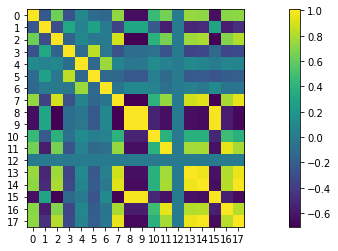

In [9]:
plot_feature_correlation_matrix(x_train)

In [10]:
@interact(
    col1 = SelectionSlider(options=np.arange(x_train.shape[1])),
    col2 = SelectionSlider(options=np.arange(x_train.shape[1])),
    
)
def explore_scatter(col1, col2):
    fig, ax = plt.subplots(1, 3)
    
    ax[0].scatter(x_train[:, col1], x_train[:, col2], c=y_train)
    ax[1].hist(x_train[:, col1])
    ax[2].hist(x_train[:, col2])

interactive(children=(SelectionSlider(description='col1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

# Model

## Softmax multiclass

In [11]:
class MultiLogRegressor():
    def __init__(self, eta, n_steps):
        self.eta = eta
        self.n_steps = n_steps
        self.train_loss = []
        self.train_error = []
        self.validation_loss = []
        self.validation_error = []
    
    def _linear_func(self, X):
        return X @ self.W + self.B # (n, d) @ (d, k) + (k, ) = (n, k)

    def _softmax(self, Z):
        Z -= np.max(Z)
        return np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True) # (n, k) / scalar, it divides every element in each column by sum of column
        
    def _loss(self, X, true_y):
        # cross entropy loss
        y_proba = self.predict_proba(X) # (n, k)
        loss = -np.log(np.sum(y_proba * true_y, axis=1))
        return np.mean(loss)
    
    def _error_rate(self, X, true_y):
        y_pred = self.predict(X)
        error_rate = np.count_nonzero(y_pred - true_y.argmax(axis=1)) / y_pred.shape[0]
        return error_rate
    
    def _gradient_descent(self, X, true_y):
        y_proba = self.predict_proba(X)
        dW = X.T @ (y_proba - true_y) / X.shape[0]
        dB = np.sum(y_proba - true_y, axis=0) / X.shape[0]
        # updates the gradient
        self.W -= self.eta * dW
        self.B -= self.eta * dB
        
    def fit(self, x_train, y_train, x_validation=None, y_validation=None):
        _, n_features = x_train.shape # n, d
        n_cls = y_train.shape[1] # k
        self.W = np.zeros((n_features, n_cls)) # (d, k)
        self.B = np.zeros(n_cls) # (k, )
        
        for _ in range(self.n_steps):
            self._gradient_descent(x_train, y_train)
            self.train_loss.append(self._loss(x_train, y_train))
            self.train_error.append(self._error_rate(x_train, y_train))
            
            if not (x_validation is None and y_validation is None):
                self.validation_loss.append(self._loss(x_validation, y_validation))
                self.validation_error.append(self._error_rate(x_validation, y_validation))
    
    def predict_proba(self, X):      
        Z = self._linear_func(X)  # X is (n, d)
        return self._softmax(Z) # (n, k)

    def predict(self, X):
        y_proba = self.predict_proba(X)
        return y_proba.argmax(axis=1)

    def plot_history(self):
        fig, ax = plt.subplots(1, 2)
        ax[0].plot([np.mean(loss) for loss in self.train_loss])
        ax[0].plot([np.mean(loss) for loss in self.validation_loss])
        ax[0].set_title("softmax_multiclass_loss")
        ax[0].legend(["train", "validation"])
        ax[1].plot([np.mean(error) for error in self.train_error])
        ax[1].plot([np.mean(error) for error in self.validation_error])
        ax[1].set_title("softmax_multiclass_error")
        ax[1].legend(["train", "validation"])
        plt.show()

In [12]:
multi = MultiLogRegressor(0.05, 100)
multi.fit(x_train, y_train, x_validation, y_validation)

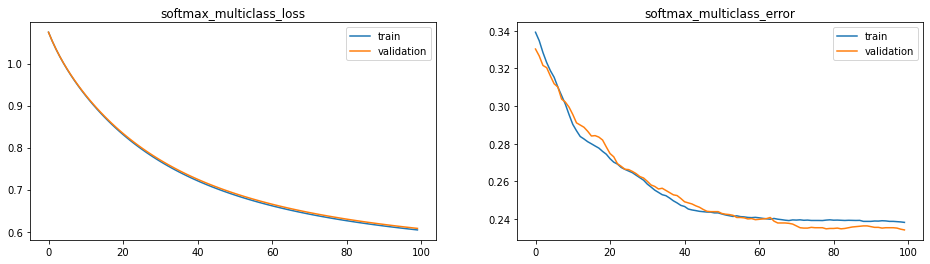

In [13]:
multi.plot_history()

In [14]:
pred_multi = multi.predict(x_test)
u_multi, c_multi = np.unique(pred_multi, return_counts=True)
print("unique pred: ", u_multi)
print("frequency pred: ", c_multi)

unique pred:  [0 2]
frequency pred:  [6824  496]


## One vs one scheme

In [15]:
class LogRegressor():
    def __init__(self, eta, n_steps):
        self.eta = eta
        self.n_steps = n_steps
        self.train_loss = []
        self.train_error = []
        self.validation_loss = []
        self.validation_error = []
    
    def _linear_func(self, X):
        return X @ self.W + self.B

    def _sigmoid(self, Z):
        denom = 1 + np.exp(-Z)
        return 1 / denom
    
    def _loss(self, X, true_y):
        y_proba = self.predict_proba(X)
        class_1_L = true_y * np.log(y_proba)
        class_0_L = (1 - true_y) * np.log(1 - y_proba)
        loss = -(class_1_L + class_0_L)
        return np.mean(loss)
    
    def _error_rate(self, X, true_y):
        y_pred = self.predict(X)
        error_rate = np.count_nonzero(true_y - y_pred) / y_pred.shape[0]
        return error_rate
    
    def _gradient_descent(self, X, true_y):
        y_proba = self.predict_proba(X)
        dW = X.T @ (y_proba - true_y) / X.shape[0] #
        dB = np.sum(y_proba - true_y, axis=0) / X.shape[0]
        self.W -= self.eta * dW
        self.B -= self.eta * dB
        
        
    def fit(self, x_train, y_train, x_validation=None, y_validation=None):
        self.W = np.zeros(x_train.shape[1])
        self.B = 0
        
        for _ in range(self.n_steps):
            self._gradient_descent(x_train, y_train)
            self.train_error.append(self._error_rate(x_train, y_train))
            self.train_loss.append(self._loss(x_train, y_train))
            
            if (x_validation != None) & (y_validation != None):
                self.validation_loss.append(self._loss(x_validation, y_validation))
                self.validation_error.append(self._error_rate(x_validation, y_validation))
    
    def predict_proba(self, X):      
        Z = self._linear_func(X)  
        return self._sigmoid(Z)

    def predict(self, X, threshold=0.5):
        y_proba = self.predict_proba(X)
        return (y_proba > threshold).astype(int)

    def plot_history(self):
        fig, ax = plt.subplots(1, 2)
        ax[0].plot([np.mean(loss) for loss in self.train_loss])
        ax[0].plot([np.mean(loss) for loss in self.validation_loss])
        ax[0].set_title("loss")
        ax[0].legend(["train", "validation"])
        ax[1].plot([np.mean(error) for error in self.train_error])
        ax[1].plot([np.mean(error) for error in self.validation_error])
        ax[1].set_title("error")
        ax[1].legend(["train", "validation"])
        plt.show()

In [16]:
class OneVOne():
    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df
        
        self.cls = list(train_df.LABELS.unique())
        self.n_cls = len(self.cls)
        
        self.label_pairs = []
        for i in range(self.n_cls):
            for j in range(i, self.n_cls-1):
                self.label_pairs.append((self.cls[i], self.cls[j+1]))
        self.n_label_pairs = len(self.label_pairs)
        
    def preprocess(self):
        self.train_samples = {}
        for pair in self.label_pairs:
            pre_train = self.train_df.loc[self.train_df.LABELS.isin(list(pair))]
            x_train, y_train = binary_xy_split(pre_train)
            self.train_samples[pair] = (x_train, y_train)
            
    def fit(self, eta, n_steps):
        self.eta = eta
        self.n_steps = n_steps
        
        self.models = {}
        for pair in self.label_pairs:
            x_train, y_train = self.train_samples[pair]
            model = LogRegressor(self.eta, self.n_steps)
            model.fit(x_train, y_train)
            self.models[pair] = model

    def predict(self, X, threshold=0.5):
        y_votes = np.zeros((X.shape[0], self.n_cls))

        for pair, model in self.models.items():
            label_min = np.min(np.asarray(pair))
            label_max = np.max(np.asarray(pair))

            y_proba = model.predict_proba(X)
            
            y_votes[:, label_min] += 1-y_proba
            y_votes[:, label_max] += y_proba
            
        return y_votes.argmax(axis=1)
    
    def plot_history(self):
        fig, ax = plt.subplots(1, 2)
        
        legend_elems = []
        
        loop_i = 0
        for pair, model in self.models.items():
            ax[0].plot([np.mean(loss) for loss in model.train_loss], color=f"C{loop_i}")
            ax[0].set_title("OneVOne_loss")
            
            ax[1].plot([np.mean(error) for error in model.train_error], color=f"C{loop_i}")
            ax[1].set_title("OneVOne_error")
            
            legend_elems.append(Patch(label=str(pair), color=f"C{loop_i}"))
            loop_i += 1
            
        ax[0].legend(handles=legend_elems)
        ax[1].legend(handles=legend_elems)
        
        plt.show()

In [17]:
# undo onehot encoding
ovo_train = pre_train.drop(columns=[0, 1, 2])
ovo_train.LABELS = ovo_train.LABELS.astype(int)

In [18]:
ovo = OneVOne(ovo_train, test_df)
ovo.preprocess()
ovo.fit(0.05, 75)

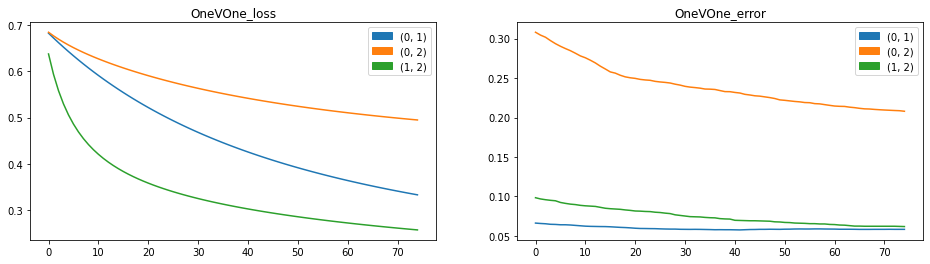

In [19]:
ovo.plot_history()

In [20]:
pred_ovo = ovo.predict(x_test)
u_ovo, c_ovo = np.unique(pred_ovo, return_counts=True)
print("unique pred: ", u_ovo)
print("frequency pred: ", c_ovo)

unique pred:  [0 1 2]
frequency pred:  [5613   86 1621]


## XGBoost

In [21]:
import xgboost
from xgboost import XGBClassifier

In [22]:
xgb = XGBClassifier(
    objective="multi:softmax",
    eval_metric=["mlogloss", "merror"],
    n_estimators=200,
    max_depth=5,
    eta=0.01,
    booster="gbtree",
    tree_method="hist",
    use_label_encoder=False,
    verbosity=0
)

In [23]:
xgb.fit(
    x_train,
    y_train.argmax(axis=1),
    eval_set=[
        (x_train, y_train.argmax(axis=1)),
        (x_validation, y_validation.argmax(axis=1))
    ]
)

[0]	validation_0-mlogloss:1.08996	validation_0-merror:0.19694	validation_1-mlogloss:1.09009	validation_1-merror:0.20803
[1]	validation_0-mlogloss:1.08145	validation_0-merror:0.19694	validation_1-mlogloss:1.08172	validation_1-merror:0.20803
[2]	validation_0-mlogloss:1.07310	validation_0-merror:0.19612	validation_1-mlogloss:1.07349	validation_1-merror:0.20842
[3]	validation_0-mlogloss:1.06484	validation_0-merror:0.19626	validation_1-mlogloss:1.06538	validation_1-merror:0.20862
[4]	validation_0-mlogloss:1.05672	validation_0-merror:0.19626	validation_1-mlogloss:1.05741	validation_1-merror:0.20803
[5]	validation_0-mlogloss:1.04873	validation_0-merror:0.19626	validation_1-mlogloss:1.04957	validation_1-merror:0.20862
[6]	validation_0-mlogloss:1.04087	validation_0-merror:0.19549	validation_1-mlogloss:1.04185	validation_1-merror:0.20706
[7]	validation_0-mlogloss:1.03314	validation_0-merror:0.19583	validation_1-mlogloss:1.03425	validation_1-merror:0.20726
[8]	validation_0-mlogloss:1.02553	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01,
              eval_metric=['mlogloss', 'merror'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

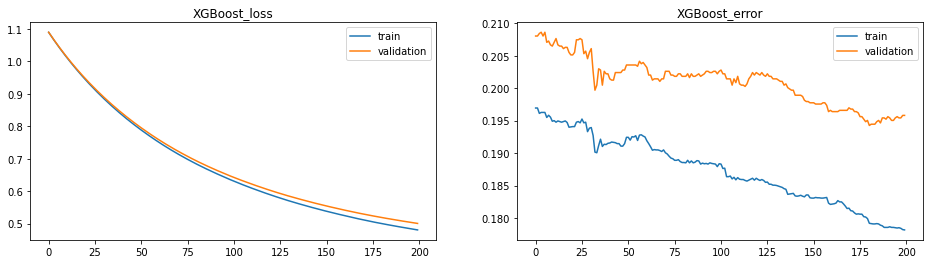

In [25]:
results = xgb.evals_result()
xx = np.arange(len(results["validation_0"]["mlogloss"]))

fig, ax = plt.subplots(1, 2)
ax[0].plot(xx, results["validation_0"]["mlogloss"])
ax[0].plot(xx, results["validation_1"]["mlogloss"])
ax[0].set_title("XGBoost_loss")
ax[0].legend(["train", "validation"])
ax[1].plot(xx, results["validation_0"]["merror"])
ax[1].plot(xx, results["validation_1"]["merror"])
ax[1].set_title("XGBoost_error")
ax[1].legend(["train", "validation"])
plt.show()

In [26]:
pred_xgb = xgb.predict(x_test)
u_xgb, c_xgb = np.unique(pred_xgb, return_counts=True)
print("unique pred: ", u_xgb)
print("frequency pred: ", c_xgb)

unique pred:  [0 1 2]
frequency pred:  [6250  121  949]


## sk-learn

Using the sklearn implementation to compare achievable accuracy and loss

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [29]:
sk_model = LogisticRegression(penalty="none", multi_class="multinomial", max_iter=100, solver="lbfgs", verbose=1)

In [30]:
sk_model.fit(x_train, y_train.argmax(axis=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\TJ\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(multi_class='multinomial', penalty='none', verbose=1)

# Producing Stats

In [33]:
multi1 ={
    "eta": 0.05,
    "n_steps": 30,
    "class0": 5992,
    "class1": 14,
    "class2": 1314,
    "train_loss": 0.7741,
    "train_error": 0.2623,
    "val_loss": 0.7717,
    "val_error": 0.2610,
}
multi2 = {
    "eta": 0.05,
    "n_steps": 75,
    "class0": 6737,
    "class1": 0,
    "class2": 583,
    "train_loss": 0.6367,
    "train_error": 0.2393,
    "val_loss": 0.6331,
    "val_error": 0.2389,
}
multi3 = {
    "eta": 0.05,
    "n_steps": 100,
    "class0": 6828,
    "class1": 0,
    "class2": 492,
    "train_loss": 0.6059,
    "train_error": 0.2383,
    "val_loss": 0.6018,
    "val_error": 0.2381,
}
multi_df = pd.DataFrame().from_records([multi1, multi2, multi3])

In [34]:
ovo1 = {
    "eta": 0.05,
    "n_steps": 30,
    "class0": 4182,
    "class1": 746,
    "class2": 2392,
    "(0, 1) loss": 0.4740,
    "(0, 1) error": 0.0589,
    "(0, 2) loss": 0.5663,
    "(0, 2) error": 0.2417,
    "(1, 2) loss": 0.3311,
    "(1, 2) error": 0.0775,
}
ovo2 = {
    "eta": 0.05,
    "n_steps": 70,
    "class0": 5612,
    "class1": 70,
    "class2": 1638,
    "(0, 1) loss": 0.3341,
    "(0, 1) error": 0.0583,
    "(0, 2) loss": 0.4957,
    "(0, 2) error": 0.2080,
    "(1, 2) loss": 0.2612,
    "(1, 2) error": 0.0622,
}
ovo3 = {
    "eta": 0.05,
    "n_steps": 100,
    "class0": 5983,
    "class1": 34,
    "class2": 1303,
    "(0, 1) loss": 0.2944,
    "(0, 1) error": 0.0583,
    "(0, 2) loss": 0.4759,
    "(0, 2) error": 0.2050,
    "(1, 2) loss": 0.2414,
    "(1, 2) error": 0.0615,
}
ovo_df = pd.DataFrame().from_records([ovo1, ovo2, ovo3])

In [35]:
xgb1 ={
    "eta": 0.05,
    "n_steps": 30,
    "class0": 6370,
    "class1": 148,
    "class2": 802,
    "train_loss": 0.5647,
    "train_error": 0.2010,
    "val_loss": 0.5720,
    "val_error": 0.2012,
}
xgb2 = {
    "eta": 0.05,
    "n_steps": 75,
    "class0": 6301,
    "class1": 134,
    "class2": 885,
    "train_loss": 0.4310,
    "train_error": 0.1884,
    "val_loss": 0.4438,
    "val_error": 0.1923,
}
xgb3 = {
    "eta": 0.05,
    "n_steps": 100,
    "class0": 6281,
    "class1": 139,
    "class2": 900,
    "train_loss": 0.4042,
    "train_error": 0.1828,
    "val_loss": 0.4196,
    "val_error": 0.1890,
}
xgb_df = pd.DataFrame().from_dict([xgb1, xgb2, xgb3])

# Export results

In [36]:
def save_pred(y, sub_id):
    original_index = test_df.index
    output_df = pd.DataFrame(y, index=original_index, columns=["LABELS"], dtype=int)
    output_df.to_csv(f"submission{sub_id}.csv")

In [ ]:
save_pred(pred_xgb, sub_id=18)

# Compare submissions

In [37]:
def load_submissions():
    fnames = [f for f in os.listdir(".") if f.startswith("submission")]
    df = pd.DataFrame()
    
    for idx, f in enumerate(fnames):
        sub = pd.read_csv(f)
        df[idx] = sub.LABELS
        
    return df

In [38]:
sub_df = load_submissions()